# Assignment 5

> Notice that this is an expansion of the notebook from Assignment 4! So, here you will find again the same functions and routines we had there.

Firstly, we load numerical and plotting libraries:

In [65]:
import math
import numpy as np
import matplotlib.pyplot as plt


# For reproducibility
SEED = 7
rng = np.random.default_rng(SEED)

## Implementing periodic boundary conditions (PBC) and minimum‑image function

Our position vectors ${\bf r}$ are defined within the domain $[0,L]^d$.

In order to ensure that it is always so, and that distances are computed in an appropriate way, we introduce two functions:
* One that brings back any position vector ${\bf r}$ to the domain $[0,L]^d$;
* One that, when computing differences such as ${\bf r}_1 - {\bf r}_2$ always takes the minimal one. 

In [66]:
def wrap_pos(r, L):
    """Wrap positions into [0, L) under PBC. r: (N,d) array."""
    return np.mod(r, L)

def min_image(dx, L):
    """Apply minimum image to displacement vectors dx."""
    return dx - L * np.round(dx / L)

## Lennard–Jones potential and inter-molecular forces

We consider the Lennard--Jones potential

$$ V_{\mathrm{LJ}}(r)=4\varepsilon\Big[\big(\tfrac{r_0}{r}\big)^{12}-\big(\tfrac{r_0}{r}\big)^{6}\Big]. $$

The associated inter-molecular radial component of the forces are then computed via

$$ F(r)=- \frac{\mathrm{d}V_{\mathrm{LJ}}}{\mathrm{d}r} = \frac{24 \varepsilon}{r_0} \left[ 2 \big(\tfrac{r_0}{r}\big)^{13}-\big(\tfrac{r_0}{r}\big)^{7} \right] , $$

Thus, the force vectors are 

$$ {\bf F} = \frac{24 \varepsilon}{r_0^2} \left[ 2 \big(\tfrac{r_0}{r}\big)^{14}-\big(\tfrac{r_0}{r}\big)^{8} \right] {\bf r} \,. $$

> We will also introduce a 'mask' such that the interactions are null if the distance between two molecules is greater than a cutoff distance $r_c$. This may be helpful to improve the efficiency of the code.

> We will work in reduced units, 'forgetting' $\varepsilon$, $r_0$.

We then define a function that outputs both the potentials, and the forces for the molecules: 

In [67]:
def lj_forces_energy(r, rc, L, tiny=0.01, r_min_cap=1.2):
    """
    Compute Lennard–Jones forces and potential energy using a plain radial cutoff.
    Reduced units (epsilon = r0 = m = 1).

    Parameters
    ----------
    r  : (N, d) ndarray
        Positions.
    rc : float
        Cutoff radius; pairs with r >= rc are ignored.
    L  : float
        Box length (square/cubic).

    Returns
    -------
    F : (N, d) ndarray
        Forces on each particle.
    U : float
        Total potential energy (pairs counted once).
    """
    N, d = r.shape
    F = np.zeros_like(r)
    U = 0.0
    rc2 = rc * rc

    for j in range(N-1):
        # minimum-image displacements from j to partners k>j
        dx = r[j+1:] - r[j]            # (N-j-1, d)
        dx = min_image(dx, L)
        r2 = np.sum(dx*dx, axis=1)     # (N-j-1,)

        # Keep only safe, interacting pairs
        mask = (r2 < rc2) & (r2 > tiny)
        if not np.any(mask):
            continue

        # --- APPLY MASK BEFORE ANY INVERSES ---
        dxm = dx[mask]                 # (M,d)
        r2m = r2[mask]                 # (M,)

        # Optional short-range cap (after masking)
        if r_min_cap is not None:
            r2m = np.maximum(r2m, r_min_cap**2)

        inv_r2  = 1.0 / r2m            # r^{-2}
        inv_r6  = inv_r2**3            # r^{-6}
        inv_r12 = inv_r6**2            # r^{-12}

        # Potential energy: sum over masked pairs
        U += np.sum(4.0*(inv_r12 - inv_r6))

        # Forces: F_jk = 24*(2 r^{-14} - r^{-8}) * dx
        f_over_r = 24.0*(2.0*inv_r12*inv_r2 - inv_r6*inv_r2)   # (M,)
        fij = f_over_r[:, None] * dxm                          # (M,d)

        # Accumulate on particle j
        F[j] += np.sum(fij, axis=0)

        # Equal-and-opposite on partners k>j, using absolute indices (robust)
        k_idx = np.nonzero(mask)[0] + (j + 1)
        F[k_idx] -= fij

    return F, U

## Choosing initial conditions

We choose the initial conditions as follows:

- **Positions:** uniform in $[0,L)$, rejecting proposals with inter‑particle distance $r \le 1$ (in reduced units).  
- **Velocities:** sample each component from a Gaussian distribution $\mathcal{N}(0, \sigma^2)$ and **subtract the centre‑of‑mass (COM)** velocity to enforce zero total momentum -- useful for later!

In [68]:
def init_positions_no_overlap(N, d, L, min_dist=1.10, max_tries=200000):
    """
    Place N particles uniformly at random in a periodic box, rejecting placements
    that come within 'min_dist' (in reduced units) of any already-placed particle.

    Parameters
    ----------
    N : int
        Number of particles.
    d : int
        Spatial dimension (2 or 3 typically).
    L : float
        Box length (assumes a cubic/square box of side L with PBC).
    min_dist : float, optional
        Minimum allowed separation (Euclidean) under PBC via minimum-image.
        If a proposed particle is <= min_dist from any existing one, it is rejected.
    max_tries : int, optional
        Hard cap on total proposal attempts to avoid infinite loops at high density.

    Returns
    -------
    r : (N, d) ndarray
        Positions in [0, L) (component-wise), with no overlaps closer than min_dist.
    """
    r = np.empty((N, d))  # output array for accepted positions
    placed = 0            # how many particles have been successfully placed
    tries = 0             # total number of proposals (accepted + rejected)

    while placed < N:
        # Propose a candidate uniformly in the primary box [0, L)^d
        candidate = rng.uniform(0.1*L, 0.9*L, size=d)

        # Check candidate against all already-placed particles
        ok = True
        for j in range(placed):
            # Minimum-image displacement to particle j (shortest vector under PBC)
            dx = min_image(candidate - r[j], L)
            # Reject if too close (<= min_dist)
            if np.linalg.norm(dx) <= min_dist:
                ok = False
                break  # no need to check further neighbours

        # Accept if it passed all checks; otherwise loop and try a new candidate
        if ok:
            r[placed] = candidate
            placed += 1

        # Bookkeeping and safety stop
        tries += 1
        if tries > max_tries:
            raise RuntimeError(
                "Could not place particles without overlap. "
                "Try smaller N, smaller min_dist, or larger L."
            )

    return r


def init_velocities_gaussian(N, d, sigma=0.2):
    """
    Draw initial velocities from an i.i.d. Gaussian and enforce zero total momentum.

    Parameters
    ----------
    N : int
        Number of particles.
    d : int
        Spatial dimension.
    sigma : float, optional
        Standard deviation per component (sets initial kinetic temperature scale).

    Returns
    -------
    v : (N, d) ndarray
        Velocities with mean per component exactly zero (COM at rest).
    """
    # Independent normal components ~ N(0, sigma^2)
    v = rng.normal(0.0, sigma, size=(N, d))

    # Subtract the centre-of-mass velocity to enforce total momentum = 0
    v -= np.mean(v, axis=0)

    return v


In [ ]:

def estimate_temperature_from_v(v):
    """
    Estimate temperature from instantaneous velocities via equipartition (reduced units).

    In reduced LJ units (k_B = m = 1), the kinetic temperature estimator is
        T = (1/d) * <||v||^2>_particles
    where v is the per-particle velocity vector at a *single* time.

    Parameters
    ----------
    v : (N, d) ndarray
        Velocities of all particles at one time.

    Returns
    -------
    T : float
        Instantaneous temperature estimate.

    """
    N, d = v.shape
    speeds2 = np.sum(v * v, axis=1)   # per-particle speed squared
    return np.mean(speeds2) / d       # average over particles, divide by d


def estimate_T_from_v_comzero(v):
    # Use your helper on COM-demeaned velocities (reduced units)
    return estimate_temperature_from_v(v - v.mean(axis=0, keepdims=True))

## Implementing velocity-Verlet and leap-frog methods

As we did in Assignment 3 to study the motion of a three-body system, we can set up a velocity-Verlet method to study the motion of the molecules.
Recall that the velocity-Verlet method updates the quantities as follows:

\begin{align}
			\mathbf{r}_j^{\,n+1}=\mathbf{r}_j^{\,n}+\Delta t\,\mathbf{v}_j^{\,n}+\tfrac12\Delta t^2\,\mathbf{a}_j^{\,n},
			\\
			\mathbf{v}_j^{\,n+1}=\mathbf{v}_j^{\,n}+\tfrac12\Delta t\big(\mathbf{a}_j^{\,n}+\mathbf{a}_j^{\,n+1}\big),
\end{align}

> Since it will be useful later on, within the function below, we also compute (and then output) the energies and momenta of the molecules.

In [70]:
def velocity_verlet(r0, v0, dt, steps, L, rc, store_traj=True):
    """
    Advance an LJ MD system with the velocity-Verlet integrator.

    Scheme:
        r_{n+1} = r_n + Δt v_n + (Δt^2/2) a_n
        a_{n+1} = a(r_{n+1})
        v_{n+1} = v_n + (Δt/2) (a_n + a_{n+1})

    Properties:
        - Time-reversible, symplectic (like leap-frog), O(Δt^2).
        - Velocities are available at integer times (handy for diagnostics).

    Parameters / Returns
    --------------------
    Same as leapfrog().
    """
    r = r0.copy()
    v = v0.copy()

    # Initial forces/energy at t = 0
    F, U = lj_forces_energy(r, rc, L)

    traj = [r.copy()] if store_traj else None
    E_list, P_list, T_list = [], [], []

    for _ in range(steps):
        # (1) Drift with current v and a_n, then wrap into box
        r = wrap_pos(r + dt * v + 0.5 * dt * dt * F, L)

        # (2) New forces/energy at updated positions
        F_new, U = lj_forces_energy(r, rc, L)

        # (3) Velocity update using average acceleration
        v = v + 0.5 * dt * (F + F_new)
        F = F_new  # advance force for next step

        # --- Diagnostics at integer time ---
        K = 0.5 * np.sum(v * v)
        P = np.sum(v, axis=0)
        E_list.append(K + U)
        P_list.append(P.copy())
        T_list.append(estimate_T_from_v_comzero(v))   # <-- NEW

        if store_traj:
            traj.append(r.copy())

    return (np.array(traj) if store_traj else None,
            np.array(E_list),
            np.array(P_list),
            np.array(T_list))


We can similarly implement the *leap-frog* method.
The leap-frog method updates the quantities as follows:

\begin{align}
			\mathbf v^{\,n+\tfrac12} &= \mathbf v^{\,n} + \frac{\Delta t}{2}\,\mathbf a^{\,n},\\
			\mathbf r^{\,n+1}        &= \mathbf r^{\,n} + \Delta t\,\mathbf v^{\,n+\tfrac12},\\
			\mathbf a^{\,n+1}        &= \frac{1}{m}\,\mathbf F \big(\mathbf r^{\,n+1}\big),\\
			\mathbf v^{\,n+1}        &= \mathbf v^{\,n+\tfrac12} + \frac{\Delta t}{2}\,\mathbf a^{\,n+1}.
		\end{align}


In [71]:
def leapfrog(r0, v0, dt, steps, L, rc, store_traj=True):
    """
    Advance an LJ MD system with the leap-frog scheme (staggered in time).

    Scheme (kick-drift-kick, with half-step velocities):
        1) Given a(t_0), form v(t_0 + Δt/2) = v(t_0) + (Δt/2) a(t_0)
        2) Drift: r(t_0 + Δt) = r(t_0) + Δt * v(t_0 + Δt/2)
        3) Compute a(t_0 + Δt) from the new positions
        4) Kick to integer time (for diagnostics): v(t_0 + Δt) = v(t_0 + Δt/2) + (Δt/2) a(t_0 + Δt)
        5) Prepare next half-step velocity: v(t_0 + 3Δt/2) = v(t_0 + Δt/2) + Δt * a(t_0 + Δt)

    Parameters
    ----------
    r0, v0 : (N, d) arrays
        Initial positions and velocities (reduced units).
    dt : float
        Time step.
    steps : int
        Number of integration steps.
    L : float
        Box length for PBC (square/cubic).
    rc : float
        Lennard–Jones cutoff (plain cutoff; forces/energy from lj_forces_energy).
    store_traj : bool
        If True, store positions at t=0 and after each step (length steps+1).

    Returns
    -------
    traj : (steps+1, N, d) array or None
        Positions along the trajectory (None if store_traj=False).
    E : (steps,) array
        Total energy per step, E = K + U, evaluated at integer times.
    P : (steps, d) array
        Total momentum vector per step, evaluated at integer times.
    """
    r = r0.copy()
    v = v0.copy()

    # Initial forces/energy at t = 0
    F, U = lj_forces_energy(r, rc, L)

    # Half-step velocity for leap-frog staggering: v(t0 + dt/2)
    v_half = v + 0.5 * dt * F

    # Optional trajectory storage (include initial positions)
    traj = [r.copy()] if store_traj else None
    E_list, P_list = [], []

    for _ in range(steps):
        # (1) Drift: advance positions with half-step velocities; then wrap into box
        r = wrap_pos(r + dt * v_half, L)

        # (2) Compute forces at the new positions (accelerations at t + dt)
        F, U = lj_forces_energy(r, rc, L)

        # (3) Kick to *integer* time to get v(t + dt) for diagnostics
        v = v_half + 0.5 * dt * F

        # --- Diagnostics at integer time ---
        K = 0.5 * np.sum(v * v)       # kinetic energy (m = 1 in reduced units)
        P = np.sum(v, axis=0)         # total momentum vector
        E_list.append(K + U)          # total energy K + U
        P_list.append(P.copy())

        # (4) Prepare next half-step: v(t + 3Δt/2) = v(t + Δt/2) + Δt a(t + Δt)
        v_half = v_half + dt * F

        if store_traj:
            traj.append(r.copy())

    return (np.array(traj) if store_traj else None,
            np.array(E_list),
            np.array(P_list))


def velocity_verlet(r0, v0, dt, steps, L, rc, store_traj=True):
    """
    Advance an LJ MD system with the velocity-Verlet integrator.

    Scheme:
        r_{n+1} = r_n + Δt v_n + (Δt^2/2) a_n
        a_{n+1} = a(r_{n+1})
        v_{n+1} = v_n + (Δt/2) (a_n + a_{n+1})

    Properties:
        - Time-reversible, symplectic (like leap-frog), O(Δt^2).
        - Velocities are available at integer times (handy for diagnostics).

    Parameters / Returns
    --------------------
    Same as leapfrog().
    """
    r = r0.copy()
    v = v0.copy()

    # Initial forces/energy at t = 0
    F, U = lj_forces_energy(r, rc, L)

    traj = [r.copy()] if store_traj else None
    E_list, P_list, T_list = [], [], []

    for _ in range(steps):
        # (1) Drift with current v and a_n, then wrap into box
        r = wrap_pos(r + dt * v + 0.5 * dt * dt * F, L)

        # (2) New forces/energy at updated positions
        F_new, U = lj_forces_energy(r, rc, L)

        # (3) Velocity update using average acceleration
        v = v + 0.5 * dt * (F + F_new)
        F = F_new  # advance force for next step

        # --- Diagnostics at integer time ---
        K = 0.5 * np.sum(v * v)
        P = np.sum(v, axis=0)
        E_list.append(K + U)
        P_list.append(P.copy())
        T_list.append(estimate_T_from_v_comzero(v))

        if store_traj:
            traj.append(r.copy())

    return (np.array(traj) if store_traj else None,
            np.array(E_list),
            np.array(P_list),
            np.array(T_list))


## Plotting functions and helpers

We now introduce some `helper' functions that will be useful to extract some important physical quantities:

- `time_vector(t_max, steps)`: Returns a length-`steps` array from `0` to `t_max` (inclusive) for plotting diagnostics sampled once per step.

- `momentum_norm(P)`: Converts a `(steps, d)` momentum history into its Euclidean norm `|P(t)|` at each step.

- `estimate_temperature_from_v(v)`: Instantaneous kinetic-temperature estimate via equipartition in reduced units: `T = mean(||v||²)/d`.

- `maxwell_boltzmann_pdf(v, d, T)`: d-dimensional Maxwell–Boltzmann speed probability distribution ($k_B = m = 1$): $f(v)\propto v^{d-1}e^{-v^2/(2T)}$.


In [72]:
def time_vector(t_max, steps):
    """
    Build a time array compatible with diagnostics sampled once per step.

    Parameters
    ----------
    t_max : float
        Final time displayed on the x-axis.
    steps : int
        Number of samples (e.g., energy values). Typically equals the number of
        integration steps you performed.

    Returns
    -------
    t : (steps,) ndarray
        Linearly spaced times from 0 to t_max *inclusive*.

    Notes
    -----
    If your integrator used a fixed step dt and produced `steps` samples at
    integer times, then t_max should be `(steps-1)*dt`, so that
    `t = [0, dt, 2dt, ..., (steps-1)dt]`.
    """
    return np.linspace(0.0, t_max, steps)


def momentum_norm(P):
    """
    Compute the Euclidean norm of the total momentum vector at each sample.

    Parameters
    ----------
    P : (steps, d) ndarray
        Total momentum vector at each sampled time (sum over particles).

    Returns
    -------
    pnorm : (steps,) ndarray
        |P(t)| for each time sample.
    """
    return np.linalg.norm(P, axis=1)




def maxwell_boltzmann_pdf(v, d, T):
    """
    d-dimensional Maxwell–Boltzmann PDF of the *speed* (not velocity component).

    Assumes reduced units (k_B = m = 1). The speed distribution is
        f(v) = C_d(T) * v^{d-1} * exp(-v^2 / (2T)),
    with
        C_d(T) = 2 * (1 / (2T))^{d/2} / Gamma(d/2).

    Parameters
    ----------
    v : array_like
        Non-negative speeds at which to evaluate the PDF.
    d : int
        Spatial dimension (2 or 3 typically).
    T : float
        Temperature.

    Returns
    -------
    pdf : ndarray
        PDF values at the provided speeds.
    """
    from math import gamma
    coef = 2.0 * (1.0 / (2.0 * T)) ** (d / 2) / gamma(d / 2)
    return coef * (v ** (d - 1)) * np.exp(- (v * v) / (2.0 * T))



...and we also introduce several plotting functions:

- `plot_trajectories(traj, L, title)`: 2D path plot of all particles within `[0, L]×[0, L]` (requires stored trajectory).

- `plot_energy(t, E)`: Line plot of total energy \(E(t)\); useful to spot drift/oscillations.

- `plot_rel_energy(t, E)`: Plots relative drift \((E-E_0)/|E_0|\) to highlight long-term energy stability.

- `plot_momentum_norm(t, P)`: Plots `|P(t)|` to check total-momentum conservation.

- `plot_speed_histogram(v_samples, d, bins=40, overlay_mb=True)`: Histogram of speeds; optionally overlays Maxwell–Boltzmann using \(T = \text{mean}(\|v\|^2)/d\).

- `plot_temperature`: Plot kinetic temperature T(t).

In [73]:
def plot_trajectories(traj, L, title="Trajectories (2D, PBC box)"):
    """
    Plot 2D particle trajectories inside the periodic box.

    Parameters
    ----------
    traj : (T, N, 2) ndarray or None
        Stored positions for T time points. If None, a message is printed.
    L : float
        Box length; sets plot limits to [0, L] in both axes.
    title : str
        Figure title.

    Notes
    -----
    - Assumes d=2 for visualisation; for 3D we would need a different view.
    - Shows raw paths; jumps at boundaries are already wrapped out by `wrap_pos`.
    """
    if traj is None:
        print("No trajectories stored (store_traj=False).")
        return
    fig, ax = plt.subplots()
    for j in range(traj.shape[1]):               # loop over particles
        ax.plot(traj[:, j, 0], traj[:, j, 1], linewidth=0.8)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(0, L); ax.set_ylim(0, L)
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_title(title)
    plt.show()


def plot_energy(t, E):
    """
    Plot total energy vs time.

    Parameters
    ----------
    t : (steps,) ndarray
        Time vector (typically from time_vector).
    E : (steps,) ndarray
        Total energy at each time sample.
    """
    fig, ax = plt.subplots()
    ax.plot(t, E, linewidth=1.0)
    ax.set_xlabel("t")
    ax.set_ylabel("E(t)")
    ax.set_title("Total energy vs time")
    plt.show()


def plot_rel_energy(t, E):
    """
    Plot relative energy drift (E - E0) / |E0| vs time.

    Parameters
    ----------
    t : (steps,) ndarray
        Time vector.
    E : (steps,) ndarray
        Total energy per sample.

    Notes
    -----
    - This highlights long-term drift; short-term oscillations may be normal for symplectic schemes.
    - If E[0] is exactly zero (rare), this normalisation is ill-defined.
    """
    fig, ax = plt.subplots()
    dE = (E - E[0]) / abs(E[0])
    ax.plot(t, dE, linewidth=1.0)
    ax.set_xlabel("t")
    ax.set_ylabel("(E−E0)/E0")
    ax.set_title("Relative energy drift")
    plt.show()


def plot_momentum_norm(t, P):
    """
    Plot the norm of total momentum vs time.

    Parameters
    ----------
    t : (steps,) ndarray
        Time vector.
    P : (steps, d) ndarray
        Total momentum vector at each time sample.
    """
    fig, ax = plt.subplots()
    ax.plot(t, momentum_norm(P), linewidth=1.0)
    ax.set_xlabel("t")
    ax.set_ylabel("|P(t)|")
    ax.set_title("Total momentum norm")
    plt.show()


def plot_speed_histogram(v_samples, d, bins=40, overlay_mb=True):
    """
    Plot a histogram of particle speeds and optionally overlay the Maxwell–Boltzmann PDF.

    Parameters
    ----------
    v_samples : (M, d) ndarray
        A collection of velocity vectors (often concatenated across time/particles).
    d : int
        Dimension for the MB reference curve.
    bins : int
        Number of histogram bins.
    overlay_mb : bool
        If True, estimate T from the sample and overlay the MB curve.

    Notes
    -----
    - Temperature is estimated as T = (1/d) * mean(||v||^2) in reduced units.
    - For better comparison, ensure sampling is taken after transients (near steady state).
    """
    fig, ax = plt.subplots()

    # Convert velocity vectors to scalar speeds
    speeds = np.linalg.norm(v_samples, axis=1)

    # Normalised histogram of speeds
    ax.hist(speeds, bins=bins, density=True, alpha=0.6)
    ax.set_xlabel("speed v"); ax.set_ylabel("density")
    ax.set_title("Speed histogram" if not overlay_mb else "Speed histogram vs MB")

    if overlay_mb:
        # Estimate T from the same samples (equipartition in reduced units)
        T_est = np.mean(np.sum(v_samples * v_samples, axis=1)) / d

        # Smooth grid for the theoretical curve, spanning the observed range
        vgrid = np.linspace(0.0, speeds.max() * 1.05, 400)
        pdf = maxwell_boltzmann_pdf(vgrid, d, T_est)

        # Overlay MB PDF
        ax.plot(vgrid, pdf, linewidth=1.5)

    plt.show()


def plot_temperature(t, T, title="Temperature vs time", smooth_window=None):
    """
    Plot kinetic temperature T(t). Optionally overlay a moving-average smoother.

    Parameters
    ----------
    t : (steps,) ndarray
        Time vector.
    T : (steps,) ndarray
        Temperature time series (e.g. from estimate_temperature_from_v).
    title : str
        Figure title.
    smooth_window : int or None
        If set to an integer >= 2, overlays a simple moving average of that width.
    """
    fig, ax = plt.subplots()
    ax.plot(t, T, linewidth=1.0, label="T(t)")
    if smooth_window is not None and smooth_window >= 2 and smooth_window <= len(T):
        # simple moving average
        import numpy as np
        w = smooth_window
        kernel = np.ones(w) / w
        T_smooth = np.convolve(T, kernel, mode="valid")
        t_smooth = t[(w-1):]
        ax.plot(t_smooth, T_smooth, linewidth=1.2, label=f"SMA (w={w})")
    ax.set_xlabel("t"); ax.set_ylabel("T")
    ax.set_title(title)
    ax.legend()
    plt.show()



## Concrete tests

We are now finally ready to perform concrete tests!
As suggested in the Assignment text, let us take the following data:

- Dimensions: **d = 2**  
- Particles: **N = 20**  
- Box length: **L = 10** (in units of $r_0$)  
- Total time: **t\_max = 10**  
- Steps: **n\_steps = 5000** (so $\Delta t = t_{\max}/(n-1)$)  
- Cutoff: **r\_c = 2.5**  

Below, we will switch `integrator` between `"vv"` (velocity‑Verlet) and `"lf"` (leap‑frog), and eventually toggle `store_traj` according to whether we wish to store them or not.


In [74]:

# --- Parameters ---
d = 2
N = 20
L = 10.0
t_max = 10.0
n_steps = 5000
dt = t_max / (n_steps - 1)
rc = 2.5

integrator = "vv"   # "vv" (velocity‑Verlet) or "lf" (leap‑frog)
store_traj = True   # set False for memory‑efficient run

# --- Initial conditions ---
r0 = init_positions_no_overlap(N, d, L, min_dist=0.5)
v0 = init_velocities_gaussian(N, d, sigma=0.1)  # zero COM enforced

# --- Run ---
if integrator == "vv":
    traj, E, P, T = velocity_verlet(r0, v0, dt, n_steps, L, rc, store_traj=store_traj)
else:
    traj, E, P, T = leapfrog(r0, v0, dt, n_steps, L, rc, store_traj=store_traj)

t = time_vector(t_max, len(E))

print(f"Integrator: {integrator}, N={N}, d={d}, L={L}, dt={dt:.5f}, rc={rc}")
print(f"Energy drift (min/mean/max of (E−E0)/|E0|): "
      f"{np.min((E-E[0])/abs(E[0])):.3e} / {np.mean((E-E[0])/abs(E[0])):.3e} / {np.max((E-E[0])/abs(E[0])):.3e}")
print(f"|P|(min/mean/max): {momentum_norm(P).min():.3e} / {momentum_norm(P).mean():.3e} / {momentum_norm(P).max():.3e}")


Integrator: vv, N=20, d=2, L=10.0, dt=0.00200, rc=2.5
Energy drift (min/mean/max of (E−E0)/|E0|): 0.000e+00 / 1.311e+00 / 1.689e+00
|P|(min/mean/max): 1.388e-17 / 6.728e-15 / 1.474e-14


Here, we plot the temperature as a function of time:

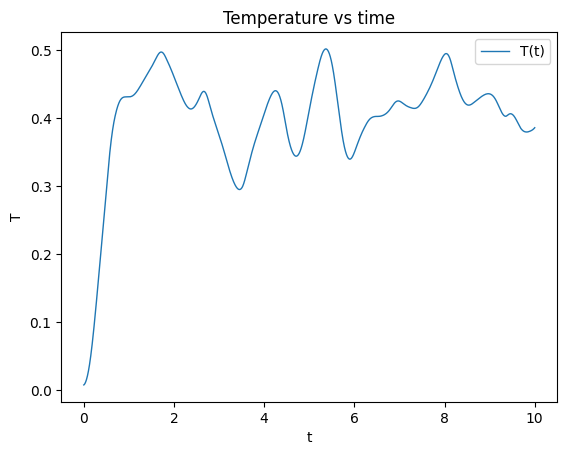

In [75]:
plot_temperature(t, T)                  

In order to check whether the velocities are distributed (roughly) according to a Maxwell-Boltzmann distribution, we need to first 'sample' the velocities. 
We will do this with the velocity-Verlet method. We may not store _all_ the velocities, but only those at every given number of steps:

In [76]:

# In this simple workflow, we re‑run for a short sampling window storing velocities explicitly.
# For teaching clarity, we implement a tiny sampler using velocity‑Verlet.

def sample_speeds_velocity_verlet(r, v, dt, steps, L, rc, sample_every=5):
    r = r.copy()
    v = v.copy()
    F, U = lj_forces_energy(r, rc, L)
    samples = []

    for n in range(steps):
        r = wrap_pos(r + dt * v + 0.5 * dt*dt * F, L)
        F_new, U = lj_forces_energy(r, rc, L)
        v = v + 0.5 * dt * (F + F_new)
        F = F_new
        if n % sample_every == 0:
            samples.append(v.copy())
    return np.concatenate(samples, axis=0)


...and we can not plot the distribution of the velocities (within a standard histogram plot), and compare what we get with the Maxwell-Boltzmann distribution:

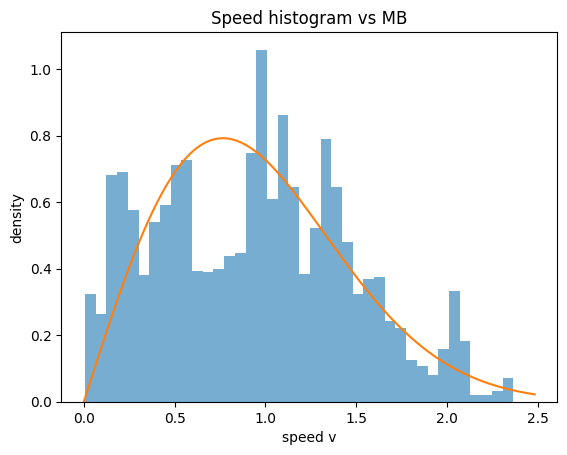

In [77]:
if traj is not None:
    # Start sampling from a late snapshot
    steps_sample = 2000
    r_start = traj[-(steps_sample//2+1)].copy()
    v_start = init_velocities_gaussian(N, d, sigma=1.0)
    v_samples = sample_speeds_velocity_verlet(r_start, v_start, dt, steps_sample, L, rc, sample_every=5)
    plot_speed_histogram(v_samples, d, bins=40, overlay_mb=True)
else:
    print("No trajectory stored; set store_traj=True above to collect a late snapshot for sampling.")

## $N^2$ particles with initial null velocity

We place $N^2$ particles on a square lattice in a square of side $L = N\,r_0$ (with lattice spacing $r_0$). We set all initial velocities to zero.

Firstly, let us assume that the particles are equally spaced. This is a symmetric configuration: for every neighbour at #\mathbf r$ there is one at $-\mathbf r$, so the net force on each particle is zero. Then, starting with $v=0$, velocity-Verlet leaves positions unchanged (up to round-off).

To check this, we do the following:

- Integrate for a short time (e.g. 300 steps);
- Print the maximum displacement $\max_i \|\mathbf r_i(t) - \mathbf r_i(0)\|$ (should be very tiny!);
- Overlay initial vs final positions; they should coincide visually.

Max displacement from initial position: 0.00e+00


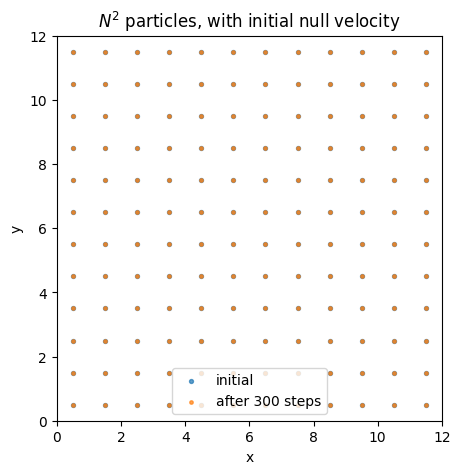

In [78]:
# --- Parameters ---
r0 = 1.0                        # LJ size parameter - we set it equal to 1
Nside = 12                      # Arbitrary choice
N = Nside * Nside               # The number of particles is N = Nside^2
L = Nside * r0                  # Side length
rc = 2.5 * r0
dt = 0.004                  

# --- Plot of the positions ---
xs = (np.arange(Nside) + 0.5) * (L / Nside)
X, Y = np.meshgrid(xs, xs, indexing="ij")
r0_cfg = np.column_stack([X.reshape(-1), Y.reshape(-1)])
v0 = np.zeros((N, 2))

traj_static, E_static, P_static, T_static = velocity_verlet(r0_cfg, v0, dt, steps=300, L=L, rc=rc, store_traj=True)
max_disp = np.linalg.norm(traj_static[-1] - traj_static[0], axis=1).max()
print(f"Max displacement from initial position: {max_disp:.2e}")

plt.figure(figsize=(5,5))
plt.scatter(traj_static[0,:,0],  traj_static[0,:,1],  s=8, label="initial", alpha=0.7)
plt.scatter(traj_static[-1,:,0], traj_static[-1,:,1], s=6, label="after 300 steps", alpha=0.7)
plt.xlim(0,L); plt.ylim(0,L); plt.gca().set_aspect("equal","box")
plt.legend(); plt.title("$N^2$ particles, with initial null velocity"); plt.xlabel("x"); plt.ylabel("y"); plt.show()

However, the perfect square lattice is a **stationary but unstable** configuration (i.e. a saddle point). 
The small displacement breaks the exact force cancellations, so the system develops non-zero forces and, under a short **relaxation** (e.g. after some iterations of velocity–Verlet), it moves toward a **lower-energy arrangement**.


To see this, with respect to the code above, we change the initial conditions:

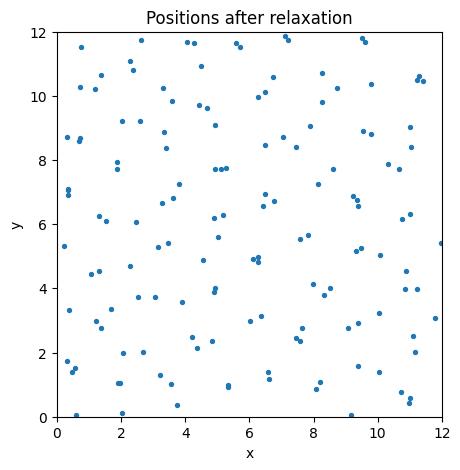

In [81]:
# choose a small noise (you can try 0.01*r0, 0.03*r0, 0.05*r0)
rc = 2.5 * r0
# rc = 3.0 * r0             # One may try different values...
dt = 0.004
epsilon = 0.05 * r0         # try 0.01*r0, 0.03*r0, 0.05*r0
steps_relax = 2000           # first segment we call "relaxation"
steps_obs   = 1200          # then "observation"
steps_total = steps_relax + steps_obs

# start from square positions, add tiny noise; keep velocities zero
rng   = np.random.default_rng(0)
r_eps = (r0_cfg + epsilon * (rng.random(r0_cfg.shape) - 0.5)) % L
v_eps = np.zeros((N, 2))

# single continuous run (same velocity_verlet as Part 1)
traj_all, E_all, P_all, T_all = velocity_verlet(
    r_eps, v_eps, dt, steps_total, L, rc, store_traj=True
)

# snapshot exactly at the end of the "relaxation" segment
r_after_relax = traj_all[steps_relax].copy()
plt.figure(figsize=(5,5))
plt.scatter(r_after_relax[:,0], r_after_relax[:,1], s=8)
plt.xlim(0, L); plt.ylim(0, L); plt.gca().set_aspect("equal","box")
plt.title("Positions after relaxation"); plt.xlabel("x"); plt.ylabel("y"); plt.show()


...and we may also plot the trajectories of the molecules:

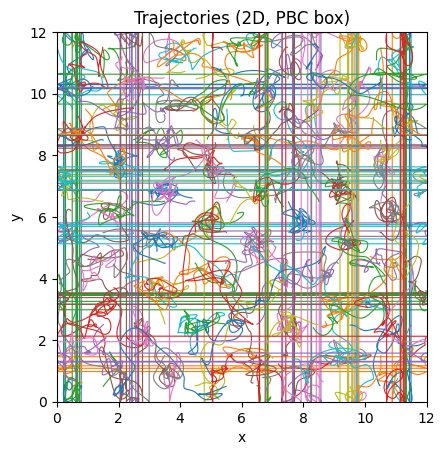

In [82]:
plot_trajectories(traj_all, L)